# 🧠 Problem Statement

---

## 🎯 Objective
Develop a **machine learning pipeline** to accurately **predict diseases** based on patient-reported symptoms.

---

## 📚 Context
You are given a dataset where each record represents a patient's symptoms and the corresponding diagnosed disease.  
The goal is to build and evaluate **multiple classification models** to identify the disease from the symptoms.

---

## ⚠️ Challenges
- The dataset is **imbalanced**, with uneven distribution of disease classes.
- Symptoms are represented as **binary features** (presence/absence).
- The model should handle **multiple disease classes** and be robust enough for **real-world predictions**.

---

## 🚀 Approach

### 1. Data Preparation
- Separate features (**symptoms**) and target labels (**disease**).
- Encode disease labels **numerically**.

### 2. Train-Test Split
- Split the dataset into **training** and **testing** sets.
- Maintain class distribution using **stratification**.

### 3. Imbalance Handling
- Apply **RandomSampler** on the training set to balance classes.

### 4. Model Training
Train multiple classifiers on the resampled training data:
- Support Vector Machine (**SVM**)
- Naive Bayes
- Random Forest
- Decision Tree
- Gradient Boosting
- Logistic Regression
- Custom **Multi-layer Perceptron (MLP)**

### 5. Model Evaluation
- Evaluate each model on the test set using **accuracy**.
- Combine predictions via **majority voting** to potentially improve performance.

### 6. Deployment
- Save the **best-performing model**, **label encoder**, and **symptom features** for future inference.
- Implement a function to **predict the disease** from new symptom inputs.

---

*Let's build a robust predictive system that can help in early disease detection and improve patient care!*


# 📚 Importing Libraries #


In [195]:
%pip install -q --upgrade scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [243]:
import numpy as np              # Numerical computations and arrays
import pandas as pd             # Data manipulation and analysis
import joblib                  # Saving and loading models
from collections import Counter  # Counting elements in iterable (e.g., class distribution)

import matplotlib.pyplot as plt  # Plotting and visualization
import seaborn as sns            # Statistical data visualization

from sklearn.metrics import (    # Evaluation metrics for model performance
    accuracy_score,
    classification_report,
    f1_score,
    mean_squared_error,
    precision_score,
    roc_auc_score,
    r2_score,
    recall_score,
confusion_matrix
)
from sklearn.metrics.pairwise import cosine_similarity  # Measure similarity between vectors

from sklearn.model_selection import (  # Model selection utilities
    GridSearchCV,      # Hyperparameter tuning
    train_test_split,  # Split data into training and test sets
)

from sklearn.preprocessing import LabelEncoder  # Encode categorical labels as numbers

# Machine learning algorithms
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB


import xgboost as xgb  # Extreme Gradient Boosting (powerful boosting algorithm)
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from scipy.stats import pearsonr




# 📂 Loading Dataset

In [197]:
df=pd.read_csv(r"/kaggle/input/improved-disease-dataset/improved_disease_dataset.csv")

# 🚀Data Exploration / EDA #

In [198]:
df.head(10)

,fever,headache,nausea,vomiting,fatigue,joint_pain,skin_rash,cough,weight_loss,yellow_eyes,disease
0,1,0,1,0,1,0,0,1,1,0,Paralysis (brain hemorrhage)
1,0,0,1,0,0,0,1,1,0,0,Paralysis (brain hemorrhage)
2,0,0,1,0,1,0,1,1,0,0,Paralysis (brain hemorrhage)
3,0,0,1,1,1,0,1,1,1,1,Paralysis (brain hemorrhage)
4,1,0,1,0,1,0,0,0,1,1,Paralysis (brain hemorrhage)
5,0,0,1,0,1,0,0,0,0,0,Paralysis (brain hemorrhage)
6,0,1,1,1,0,0,0,1,0,0,Paralysis (brain hemorrhage)
7,0,1,1,0,1,0,0,0,1,0,Paralysis (brain hemorrhage)
8,0,0,1,1,1,0,0,1,0,0,Paralysis (brain hemorrhage)
9,1,0,0,1,0,0,0,1,1,0,Paralysis (brain hemorrhage)


In [199]:
df.shape

(2000, 11)

In [200]:
df.columns

Index(['fever', 'headache', 'nausea', 'vomiting', 'fatigue', 'joint_pain',
       'skin_rash', 'cough', 'weight_loss', 'yellow_eyes', 'disease'],
      dtype='object')

In [201]:
print("Factors for the diseases are ",','.join(df.columns[:-1]))

Factors for the diseases are  fever,headache,nausea,vomiting,fatigue,joint_pain,skin_rash,cough,weight_loss,yellow_eyes


In [202]:
print("We have to predict",df.columns[-1])

We have to predict disease


In [203]:
print(f"Total {df[df.columns[-1]].nunique()} disease data given ")

Total 38 disease data given 


## 🚫missing values ##

In [204]:
df.isnull().sum()

fever          0
headache       0
nausea         0
vomiting       0
fatigue        0
joint_pain     0
skin_rash      0
cough          0
weight_loss    0
yellow_eyes    0
disease        0
dtype: int64

In [205]:
df.dtypes

fever           int64
headache        int64
nausea          int64
vomiting        int64
fatigue         int64
joint_pain      int64
skin_rash       int64
cough           int64
weight_loss     int64
yellow_eyes     int64
disease        object
dtype: object

In [206]:
df.iloc[:,0].value_counts()

fever
0    1344
1     656
Name: count, dtype: int64

## 📊summary stats, distributions ##

In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   fever        2000 non-null   int64 
 1   headache     2000 non-null   int64 
 2   nausea       2000 non-null   int64 
 3   vomiting     2000 non-null   int64 
 4   fatigue      2000 non-null   int64 
 5   joint_pain   2000 non-null   int64 
 6   skin_rash    2000 non-null   int64 
 7   cough        2000 non-null   int64 
 8   weight_loss  2000 non-null   int64 
 9   yellow_eyes  2000 non-null   int64 
 10  disease      2000 non-null   object
dtypes: int64(10), object(1)
memory usage: 172.0+ KB


In [208]:
df.describe()

,fever,headache,nausea,vomiting,fatigue,joint_pain,skin_rash,cough,weight_loss,yellow_eyes
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000
mean,0.328000,0.413000,0.378500,0.526000,0.365500,0.450500,0.387000,0.55500,0.456000,0.449000
std,0.469602,0.492496,0.485134,0.499448,0.481691,0.497668,0.487185,0.49709,0.498185,0.497517
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


## 🔍 Checking duplicates ##


In [209]:
duplicates_mask = df.duplicated(keep='last')


def find_duplicate_of(df):
    last_occurrence = df[~duplicates_mask]
    last_occurrence_dict = {tuple(row): idx for idx, row in last_occurrence.iterrows()}

    duplicate_of = []
    for idx, row in df.iterrows():
        row_tuple = tuple(row)
        if duplicates_mask[idx]:
            # Find last occurrence index this duplicates
            duplicate_of.append(last_occurrence_dict[row_tuple])
        else:
            duplicate_of.append(0)
    return duplicate_of
df1=df.copy()
df1['Duplicate_of'] = find_duplicate_of(df1)

# Now you can style as before
def color_rows(row):
    if duplicates_mask[row.name]:
        return ['background-color: red'] * len(row)
    else:
        return ['background-color: lightgreen'] * len(row)

styled_df = df1[:50].style.apply(color_rows, axis=1)
styled_df



,fever,headache,nausea,vomiting,fatigue,joint_pain,skin_rash,cough,weight_loss,yellow_eyes,disease,Duplicate_of
0,1,0,1,0,1,0,0,1,1,0,Paralysis (brain hemorrhage),19
1,0,0,1,0,0,0,1,1,0,0,Paralysis (brain hemorrhage),0
2,0,0,1,0,1,0,1,1,0,0,Paralysis (brain hemorrhage),85
3,0,0,1,1,1,0,1,1,1,1,Paralysis (brain hemorrhage),0
4,1,0,1,0,1,0,0,0,1,1,Paralysis (brain hemorrhage),0
5,0,0,1,0,1,0,0,0,0,0,Paralysis (brain hemorrhage),47
6,0,1,1,1,0,0,0,1,0,0,Paralysis (brain hemorrhage),0
7,0,1,1,0,1,0,0,0,1,0,Paralysis (brain hemorrhage),34
8,0,0,1,1,1,0,0,1,0,0,Paralysis (brain hemorrhage),72
9,1,0,0,1,0,0,0,1,1,0,Paralysis (brain hemorrhage),0


In [210]:
df

,fever,headache,nausea,vomiting,fatigue,joint_pain,skin_rash,cough,weight_loss,yellow_eyes,disease
0,1,0,1,0,1,0,0,1,1,0,Paralysis (brain hemorrhage)
1,0,0,1,0,0,0,1,1,0,0,Paralysis (brain hemorrhage)
2,0,0,1,0,1,0,1,1,0,0,Paralysis (brain hemorrhage)
3,0,0,1,1,1,0,1,1,1,1,Paralysis (brain hemorrhage)
4,1,0,1,0,1,0,0,0,1,1,Paralysis (brain hemorrhage)
...,...,...,...,...,...,...,...,...,...,...,...
1995,1,1,0,0,1,0,0,0,1,1,Alcoholic hepatitis
1996,1,0,0,0,1,1,1,0,1,1,Alcoholic hepatitis
1997,1,0,0,1,0,0,0,0,0,1,Alcoholic hepatitis
1998,0,0,0,0,1,1,0,0,0,1,Alcoholic hepatitis


In [211]:
df[df.duplicated()][df.columns[-1]].value_counts()

disease
Hepatitis B                                       34
Paralysis (brain hemorrhage)                      33
Hypertension                                      30
Impetigo                                          29
Hepatitis C                                       28
Dimorphic hemorrhoids(piles)                      26
Vertigo (Benign paroxysmal Positional Vertigo)    25
Typhoid                                           22
Malaria                                           21
Chronic cholestasis                               19
Cervical spondylosis                              19
Osteoarthritis                                    17
Bronchial Asthma                                  17
Gastroenteritis                                   16
Hyperthyroidism                                   15
Heart attack                                      14
Tuberculosis                                      13
Diabetes                                          12
Acne                                  

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

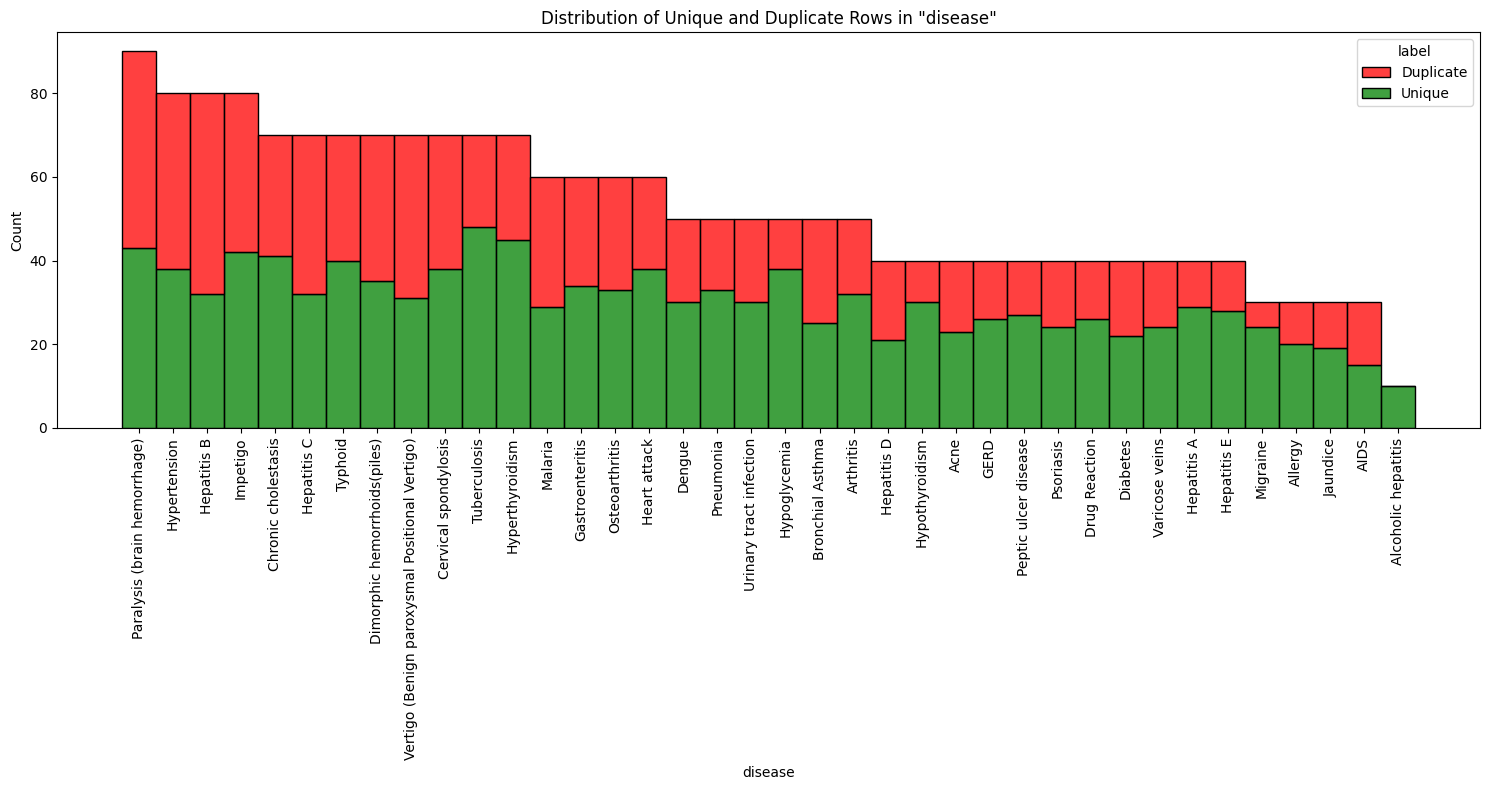

In [212]:
col = df.columns[-1]

df_plot = df.copy()
df_plot['is_duplicate'] = df.duplicated(keep=False)  # True for all duplicates

# Label the rows for clarity
df_plot['label'] = df_plot['is_duplicate'].map({True: 'Duplicate', False: 'Unique'})

# Plotting
plt.figure(figsize=(15, 8))
sns.histplot(data=df_plot, x=col, hue='label', multiple='stack',
             palette={'Duplicate': 'red', 'Unique': 'green'}, kde=False)

plt.xticks(rotation=90)
plt.xlabel(col)
plt.ylabel('Count')
plt.title(f'Distribution of Unique and Duplicate Rows in "{col}"')
plt.tight_layout()
plt.show()


In [213]:
df.duplicated().sum()

568

## 🔄️Frequency of the Diseases ##


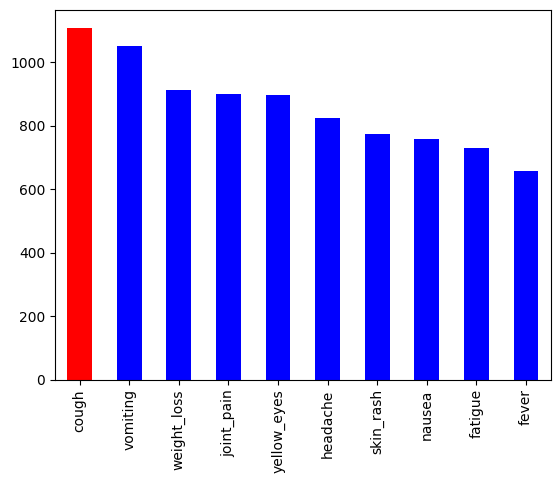

In [214]:
frequency_df=df.iloc[:,:-1].sum().sort_values(ascending=False)

color=['red' if i==frequency_df.max() else 'blue' for i in frequency_df]
frequency_df.plot(kind='bar',color=color)



plt.show()

In [215]:
df['disease'].value_counts().sort_values()

disease
Alcoholic hepatitis                               10
Migraine                                          30
AIDS                                              30
Jaundice                                          30
Allergy                                           30
Hepatitis D                                       40
Hypothyroidism                                    40
Acne                                              40
GERD                                              40
Peptic ulcer disease                              40
Diabetes                                          40
Varicose veins                                    40
Hepatitis A                                       40
Hepatitis E                                       40
Psoriasis                                         40
Drug Reaction                                     40
Urinary tract infection                           50
Pneumonia                                         50
Dengue                                

In [216]:
# Group by disease, take mean to get average symptom pattern
disease_symptoms = df.groupby('disease').mean(numeric_only=True)

disease_symptoms

,fever,headache,nausea,vomiting,fatigue,joint_pain,skin_rash,cough,weight_loss,yellow_eyes
disease,,,,,,,,,,
AIDS,0.133333,0.866667,0.900000,0.033333,0.300000,0.900000,0.800000,0.833333,0.233333,0.166667
Acne,0.225000,0.175000,0.300000,0.150000,0.150000,0.900000,0.125000,0.875000,0.825000,0.225000
Alcoholic hepatitis,0.800000,0.200000,0.100000,0.300000,0.700000,0.400000,0.200000,0.000000,0.200000,1.000000
Allergy,0.166667,0.233333,0.400000,0.100000,0.166667,0.866667,0.166667,0.733333,0.100000,0.800000
Arthritis,0.720000,0.200000,0.120000,0.860000,0.800000,0.240000,0.200000,0.820000,0.260000,0.360000
Bronchial Asthma,0.120000,0.820000,0.780000,0.220000,0.260000,0.120000,0.200000,0.860000,0.160000,0.140000
Cervical spondylosis,0.700000,0.214286,0.814286,0.742857,0.214286,0.185714,0.185714,0.242857,0.800000,0.785714
Chronic cholestasis,0.314286,0.728571,0.214286,0.800000,0.242857,0.771429,0.157143,0.185714,0.200000,0.785714
Dengue,0.100000,0.180000,0.320000,0.820000,0.240000,0.200000,0.800000,0.840000,0.300000,0.180000


In [217]:
# Compute cosine similarity between diseases
similarity_matrix = pd.DataFrame(
    cosine_similarity(disease_symptoms),
    index=disease_symptoms.index,
    columns=disease_symptoms.index
)


similarity_matrix

disease,AIDS,Acne,Alcoholic hepatitis,Allergy,Arthritis,Bronchial Asthma,Cervical spondylosis,Chronic cholestasis,Dengue,Diabetes,...,Osteoarthritis,Paralysis (brain hemorrhage),Peptic ulcer disease,Pneumonia,Psoriasis,Tuberculosis,Typhoid,Urinary tract infection,Varicose veins,Vertigo (Benign paroxysmal Positional Vertigo)
disease,,,,,,,,,,,,,,,,,,,,,
AIDS,1.000000,0.753780,0.423142,0.783726,0.541368,0.864272,0.549991,0.654690,0.714334,0.564942,...,0.591498,0.778914,0.892904,0.757622,0.507846,0.773469,0.643444,0.584885,0.675448,0.579478
Acne,0.753780,1.000000,0.463489,0.813707,0.637644,0.638223,0.641217,0.626922,0.655407,0.492075,...,0.796928,0.673773,0.522883,0.638127,0.751259,0.759442,0.725786,0.610902,0.563275,0.594450
Alcoholic hepatitis,0.423142,0.463489,1.000000,0.659736,0.736591,0.355962,0.748125,0.768047,0.426076,0.844276,...,0.628655,0.535793,0.477829,0.663413,0.576554,0.564254,0.539315,0.646219,0.572687,0.758211
Allergy,0.783726,0.813707,0.659736,1.000000,0.621081,0.660282,0.628685,0.776726,0.607388,0.680118,...,0.730690,0.679891,0.549951,0.679775,0.543023,0.614833,0.610141,0.444843,0.588182,0.785714
Arthritis,0.541368,0.637644,0.736591,0.621081,1.000000,0.627016,0.730503,0.708361,0.789815,0.679644,...,0.713956,0.795571,0.516791,0.596841,0.893068,0.713611,0.835688,0.703870,0.881422,0.645285
Bronchial Asthma,0.864272,0.638223,0.355962,0.660282,0.627016,1.000000,0.605493,0.596732,0.704596,0.569613,...,0.646335,0.845553,0.800475,0.611561,0.603528,0.737719,0.765841,0.438601,0.806229,0.417875
Cervical spondylosis,0.549991,0.641217,0.748125,0.628685,0.730503,0.605493,1.000000,0.749708,0.654007,0.896610,...,0.806600,0.666474,0.626077,0.625748,0.821405,0.709086,0.801288,0.626517,0.588510,0.711945
Chronic cholestasis,0.654690,0.626922,0.768047,0.776726,0.708361,0.596732,0.749708,1.000000,0.625655,0.706755,...,0.638737,0.536856,0.631474,0.816356,0.650611,0.629404,0.608315,0.549136,0.738632,0.942949
Dengue,0.714334,0.655407,0.426076,0.607388,0.789815,0.704596,0.654007,0.625655,1.000000,0.543887,...,0.721765,0.748797,0.699873,0.496505,0.778741,0.769784,0.800526,0.710463,0.781249,0.628475


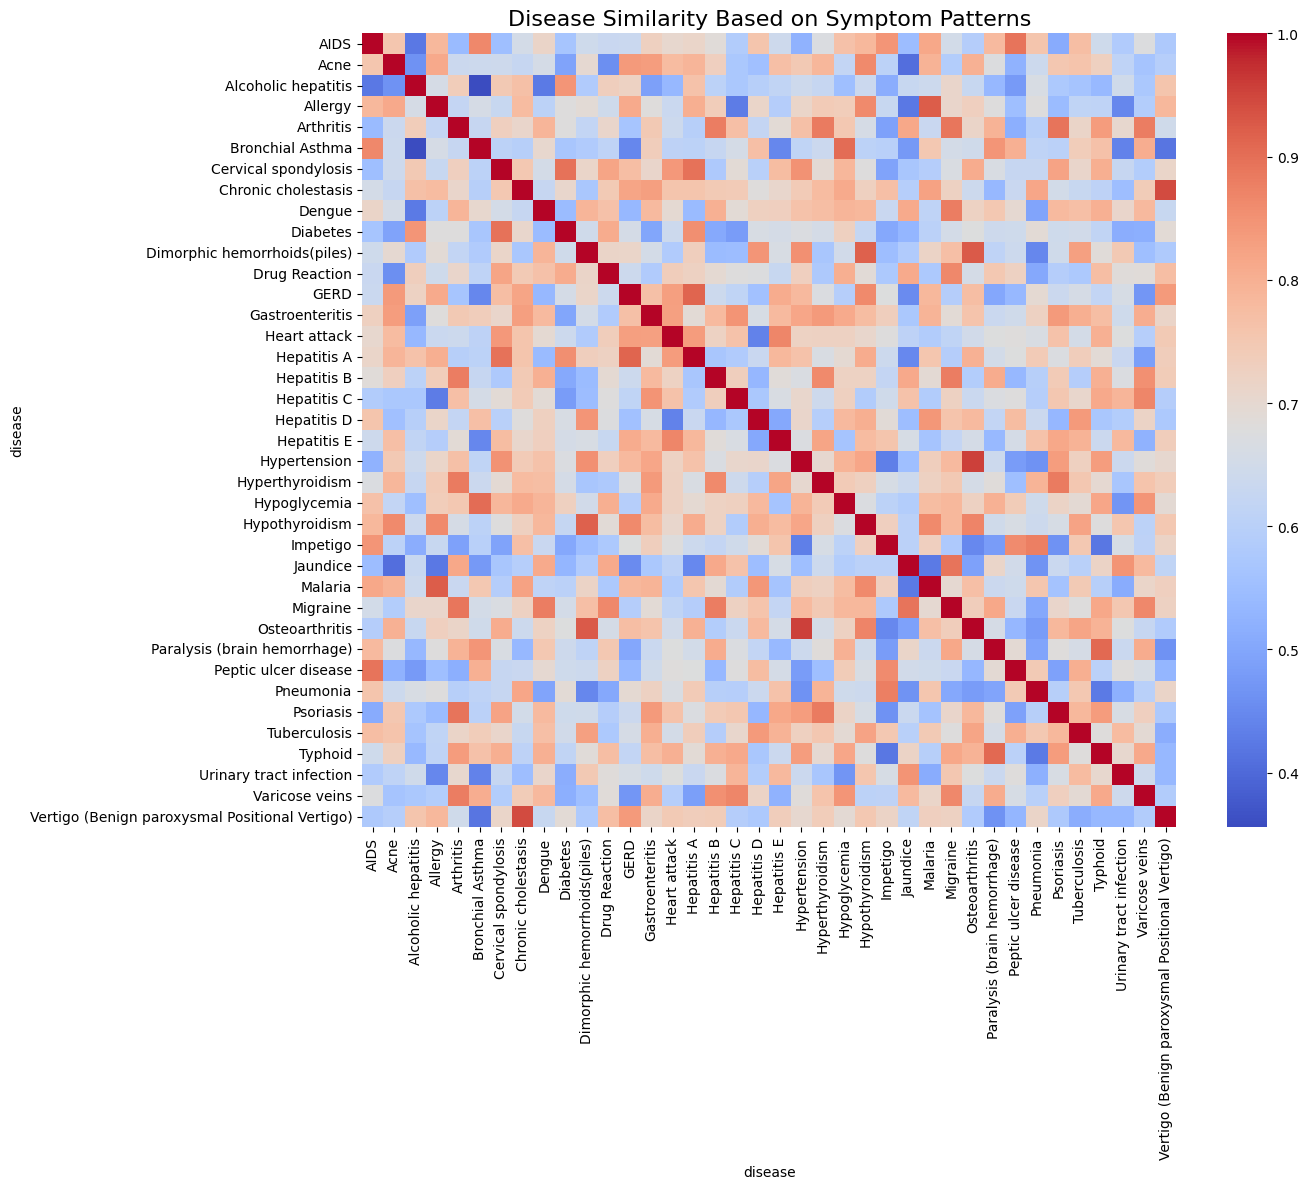

In [218]:
plt.figure(figsize=(14, 12))
sns.heatmap(similarity_matrix, cmap='coolwarm', annot=False)
plt.title("Disease Similarity Based on Symptom Patterns", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## 🥅closest disease matches ##

In [219]:
def top_related(sim_matrix, top_n=3):
    related = {}
    for disease in sim_matrix.index:
        similar = sim_matrix.loc[disease].drop(disease).sort_values(ascending=False).head(top_n)
        related[disease] = list(similar.index)
    return related

related_diseases = top_related(similarity_matrix)
pd.DataFrame.from_dict(related_diseases, orient='index', columns=['1st', '2nd', '3rd'])



top_related(similarity_matrix, top_n=3)


{'AIDS': ['Peptic ulcer disease', 'Bronchial Asthma', 'Impetigo'],
 'Acne': ['Hypothyroidism', 'GERD', 'Gastroenteritis'],
 'Alcoholic hepatitis': ['Diabetes', 'Chronic cholestasis', 'Hepatitis A'],
 'Allergy': ['Malaria', 'Hypothyroidism', 'Acne'],
 'Arthritis': ['Psoriasis', 'Migraine', 'Hyperthyroidism'],
 'Bronchial Asthma': ['Hypoglycemia', 'AIDS', 'Paralysis (brain hemorrhage)'],
 'Cervical spondylosis': ['Diabetes', 'Hepatitis A', 'Hypertension'],
 'Chronic cholestasis': ['Vertigo (Benign paroxysmal Positional Vertigo)',
  'Gastroenteritis',
  'Malaria'],
 'Dengue': ['Migraine', 'Jaundice', 'Typhoid'],
 'Diabetes': ['Cervical spondylosis', 'Hepatitis A', 'Alcoholic hepatitis'],
 'Dimorphic hemorrhoids(piles)': ['Osteoarthritis',
  'Hypothyroidism',
  'Hypertension'],
 'Drug Reaction': ['Migraine', 'Cervical spondylosis', 'Jaundice'],
 'GERD': ['Hepatitis A',
  'Hypothyroidism',
  'Vertigo (Benign paroxysmal Positional Vertigo)'],
 'Gastroenteritis': ['Hepatitis C', 'Psoriasis', 

# 🤖Model Training #

## 🏷️Label Encoder ##


In [220]:
X=df.drop(columns=df.columns[-1],axis=1)
le=LabelEncoder()
y=le.fit_transform(df[df.columns[-1]])


##  📝Train-Test Split ##

In [221]:
X_train, X_test, y_train, y_test =train_test_split(X,y,random_state=42,train_size=0.6,stratify=y)


## ✖️Handling Imbalanced Data (applying RandomOverSampler) ##

In [222]:

# Create the oversampler
ros = RandomOverSampler(random_state=42)

# Fit and resample
X_train, y_train = ros.fit_resample(X_train, y_train)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2052, 10) (2052,) (800, 10) (800,)


## 🤖 Model Selection  ##


In [246]:
# def plot_actual_vs_predicted(y_pred, title="Actual vs Predicted"):
#     """
#     Plots Actual vs Predicted values as a scatter plot.
    
#     Parameters:
#     - y_test: Ground truth labels
#     - y_pred: Predicted labels
#     - title: Title for the plot
#     """
#     import matplotlib.pyplot as plt

#     plt.figure(figsize=(8, 6))
#     plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='w')
#     plt.xlabel("Actual")
#     plt.ylabel("Predicted")
#     plt.title(title)
    
#     # Plot a 45-degree reference line
#     min_val = min(y_test.min(), y_pred.min())
#     max_val = max(y_test.max(), y_pred.max())
#     plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()






def plot_actual_vs_predicted(y_pred, title="Actual vs Predicted"):
    """
    Plots Actual vs Predicted values as a scatter plot with metrics and styling.
    
    Parameters:
    - y_test: Ground truth labels (numpy array or pandas series)
    - y_pred: Predicted labels (numpy array or pandas series)
    - title: Title for the plot
    """
    plt.figure(figsize=(10, 8))
    
    # Scatter plot with jitter if needed (optional)
    jitter = 0.1  # small noise to separate overlapping points if discrete
    if np.issubdtype(y_test.dtype, np.integer):
        y_test_jitter = y_test + np.random.uniform(-jitter, jitter, size=len(y_test))
        y_pred_jitter = y_pred + np.random.uniform(-jitter, jitter, size=len(y_pred))
    else:
        y_test_jitter = y_test
        y_pred_jitter = y_pred

    plt.scatter(y_test_jitter, y_pred_jitter, alpha=0.6, edgecolors='k', s=80, c='cornflowerblue')
    
    plt.xlabel("Actual", fontsize=14)
    plt.ylabel("Predicted", fontsize=14)
    plt.title(title, fontsize=18, fontweight='bold')
    
    # Plot 45-degree reference line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Calculate and display metrics: Pearson r and RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r, _ = pearsonr(y_test, y_pred)
    
    metric_text = f"Pearson r = {r:.3f}\nRMSE = {rmse:.3f}"
    plt.text(0.05, 0.95, metric_text, transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='whitesmoke', alpha=0.7))
    
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [224]:
def evaluate_classification_model(y_true, y_pred, y_proba=None, labels=None):
    """
    Prints classification metrics and plots confusion matrix.
    
    Parameters:
    - y_true: array-like of true labels
    - y_pred: array-like of predicted labels
    - y_proba: array-like of predicted probabilities for positive class (optional, for ROC AUC)
    - labels: list of label names/classes (optional, for confusion matrix display)
    - figsize: tuple for figure size
    
    Prints:
    - Accuracy, Precision, Recall, F1 Score, ROC AUC (if y_proba provided)
    - Classification report
    - Confusion matrix plot
    """
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"F1 Score:  {f1_score(y_true, y_pred, average='weighted'):.4f}")

    if labels is None:
        labels = np.unique(y_true)
    
    if y_proba is not None:
        try:
            roc_auc = roc_auc_score(y_true, y_proba, multi_class='ovr')
            print(f"ROC AUC:   {roc_auc:.4f}")
        except Exception as e:
            print(f"ROC AUC could not be computed: {e}")
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


---

## 🔢 1. Logistic Regression

Logistic Regression is a simple yet effective classification algorithm that models the probability of class membership using a logistic function.  
It is well-suited for linearly separable datasets and provides interpretable results.

---


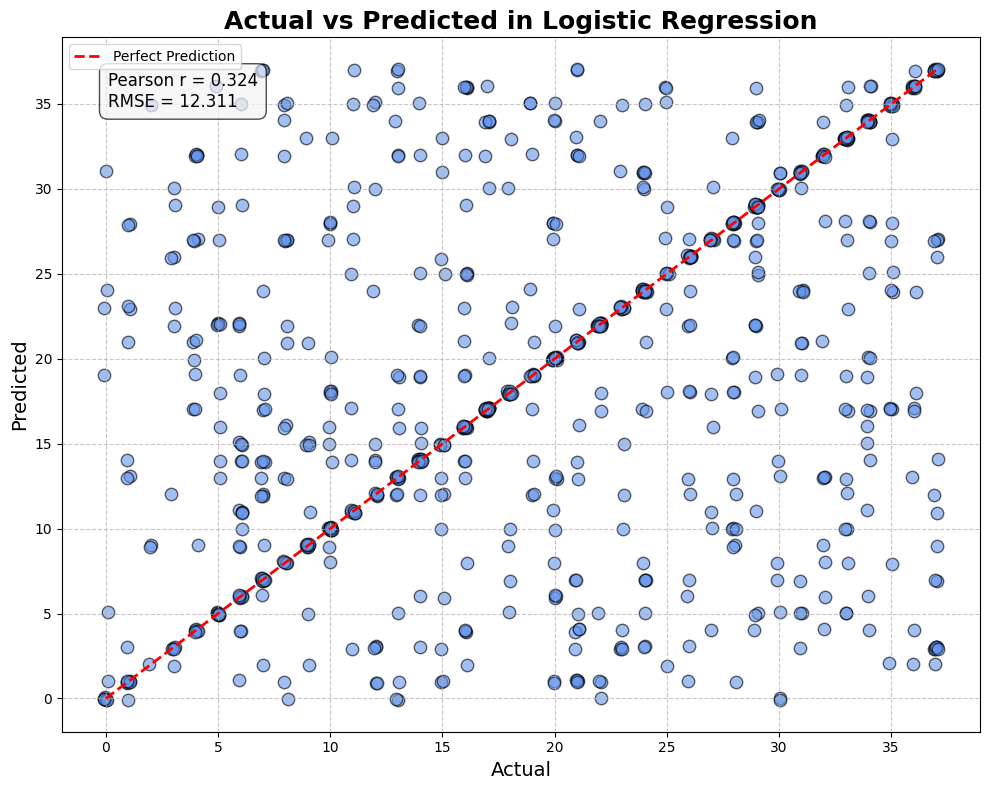

Accuracy:  0.4062
Precision: 0.4381
Recall:    0.4062
F1 Score:  0.4103

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.50      0.48        12
           1       0.25      0.38      0.30        16
           2       0.11      0.25      0.15         4
           3       0.15      0.33      0.21        12
           4       0.26      0.25      0.26        20
           5       0.39      0.45      0.42        20
           6       0.40      0.21      0.28        28
           7       0.45      0.32      0.38        28
           8       0.33      0.20      0.25        20
           9       0.40      0.50      0.44        16
          10       0.54      0.46      0.50        28
          11       0.41      0.44      0.42        16
          12       0.20      0.25      0.22        16
          13       0.29      0.33      0.31        24
          14       0.40      0.50      0.44        24
          15       0.27      0.25      

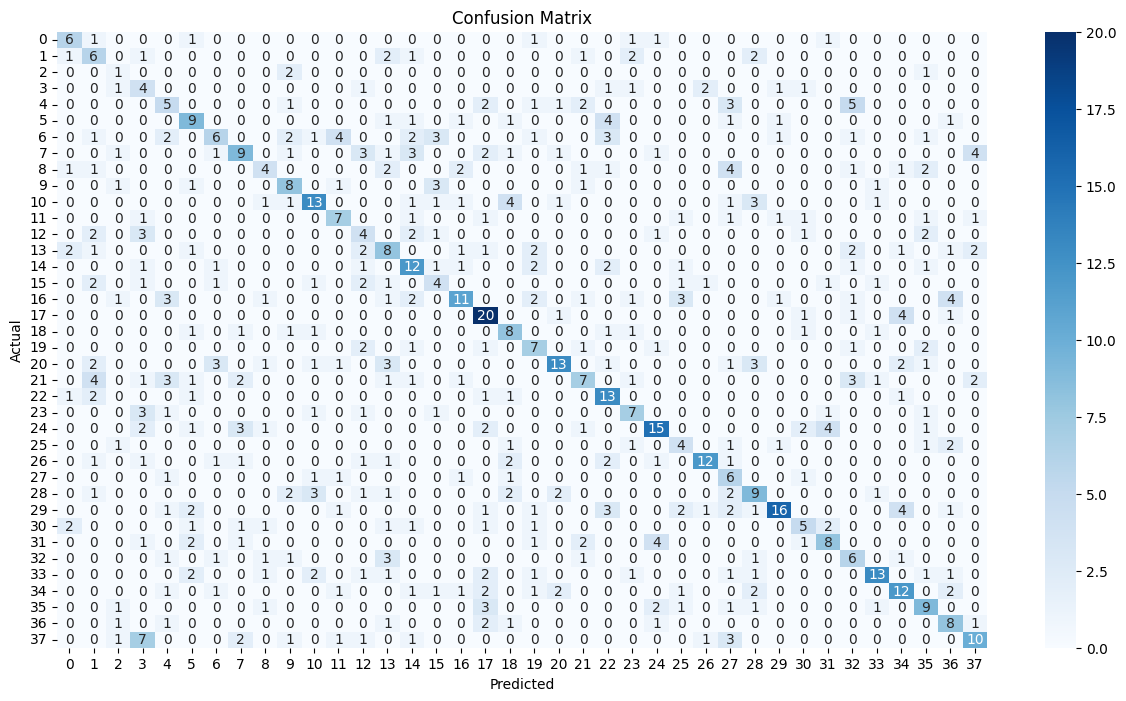

In [247]:
log=LogisticRegression()
log.fit(X_train,y_train)
y_log_predict=log.predict(X_test)

plot_actual_vs_predicted(y_log_predict,title="Actual vs Predicted in Logistic Regression")
evaluate_classification_model(y_test,y_log_predict)


## 🌳 2. Decision Tree

A **Decision Tree** is a non-parametric supervised learning algorithm used for classification and regression.  
It splits the data based on feature values to create a tree-like structure where each node represents a decision rule.

Decision Trees are:
- Easy to interpret and visualize 🧩
- Able to handle both numerical and categorical data
- Prone to overfitting (can be controlled using max depth, pruning, etc.)

We'll train a Decision Tree classifier and evaluate its performance on the test set.

---

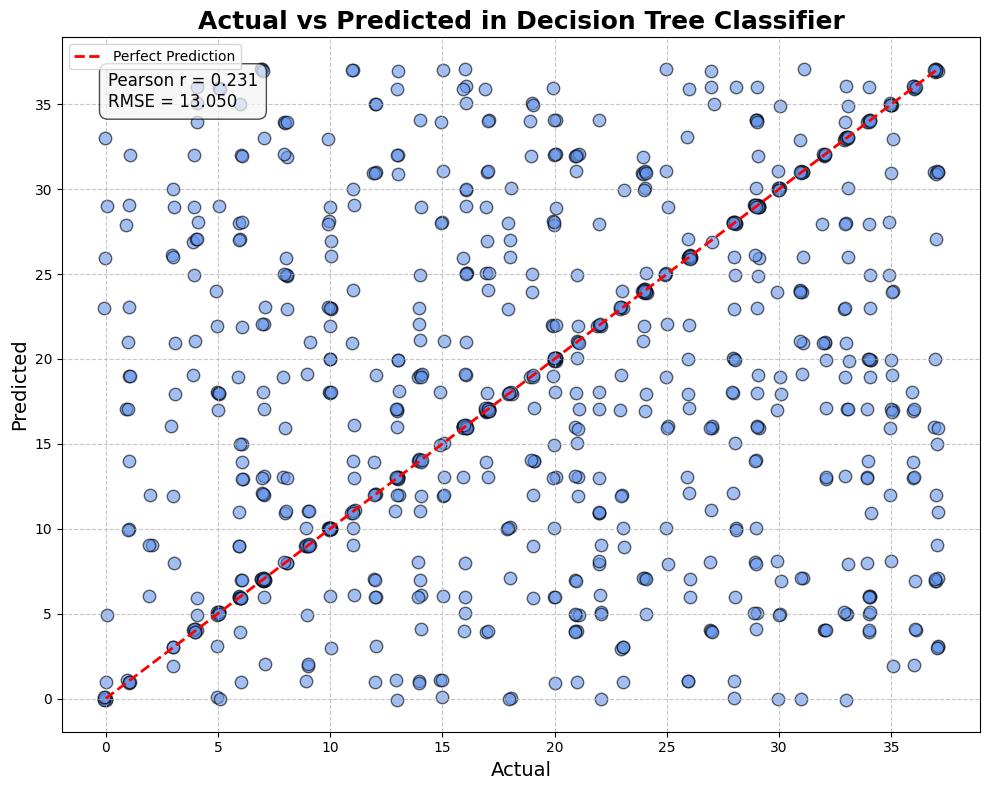

Accuracy:  0.3000
Precision: 0.3179
Recall:    0.3000
F1 Score:  0.3024

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.50      0.41        12
           1       0.21      0.25      0.23        16
           2       0.00      0.00      0.00         4
           3       0.18      0.17      0.17        12
           4       0.24      0.30      0.27        20
           5       0.27      0.35      0.30        20
           6       0.25      0.25      0.25        28
           7       0.38      0.43      0.40        28
           8       0.19      0.15      0.17        20
           9       0.44      0.44      0.44        16
          10       0.43      0.36      0.39        28
          11       0.24      0.25      0.24        16
          12       0.14      0.19      0.16        16
          13       0.23      0.29      0.26        24
          14       0.29      0.21      0.24        24
          15       0.25      0.12      

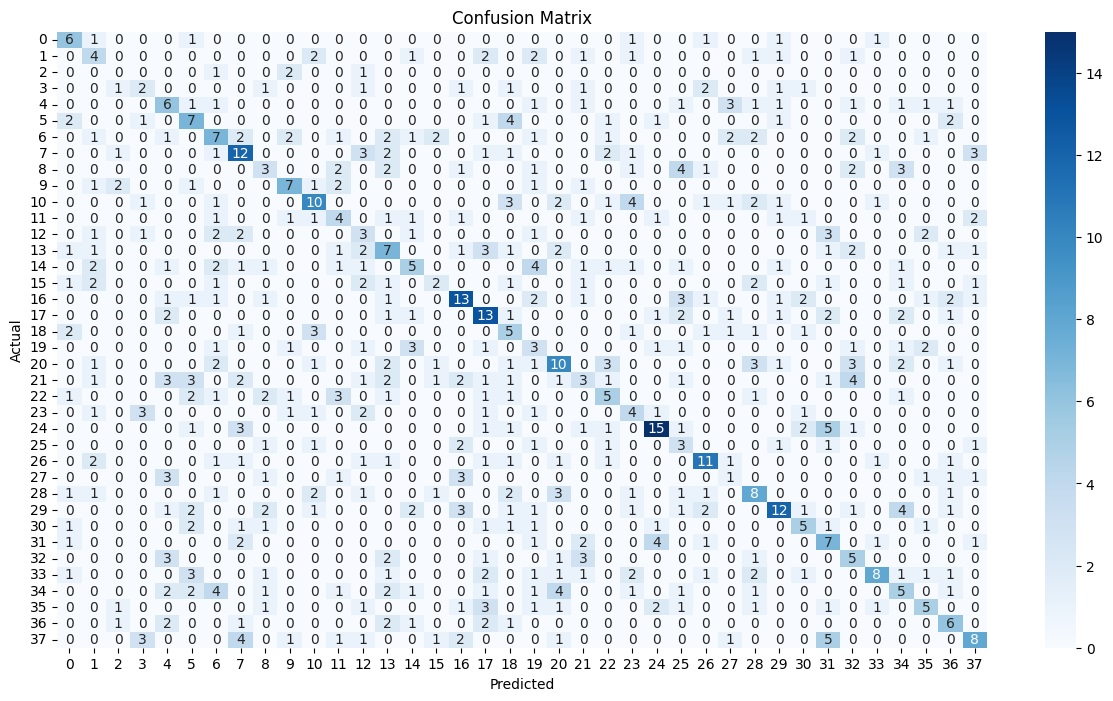

In [248]:

dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train,y_train)
y_tree_predict=dtree.predict(X_test)

plot_actual_vs_predicted(y_tree_predict,title="Actual vs Predicted in Decision Tree Classifier")

evaluate_classification_model(y_test,y_tree_predict)


## 🎋 3.RandomForestClassifier ##


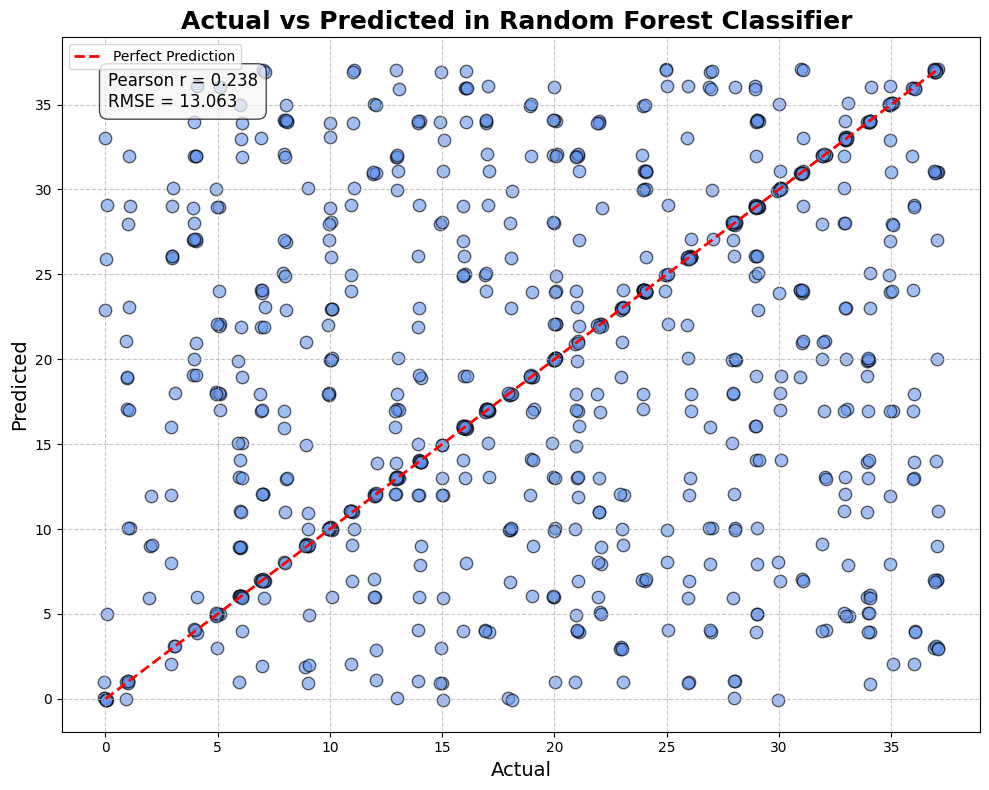

Accuracy:  0.3113
Precision: 0.3273
Recall:    0.3113
F1 Score:  0.3135

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.50      0.48        12
           1       0.21      0.25      0.23        16
           2       0.00      0.00      0.00         4
           3       0.17      0.17      0.17        12
           4       0.14      0.15      0.14        20
           5       0.33      0.30      0.32        20
           6       0.31      0.29      0.30        28
           7       0.42      0.39      0.41        28
           8       0.15      0.10      0.12        20
           9       0.35      0.44      0.39        16
          10       0.36      0.36      0.36        28
          11       0.36      0.31      0.33        16
          12       0.21      0.31      0.25        16
          13       0.27      0.29      0.28        24
          14       0.35      0.29      0.32        24
          15       0.20      0.12      

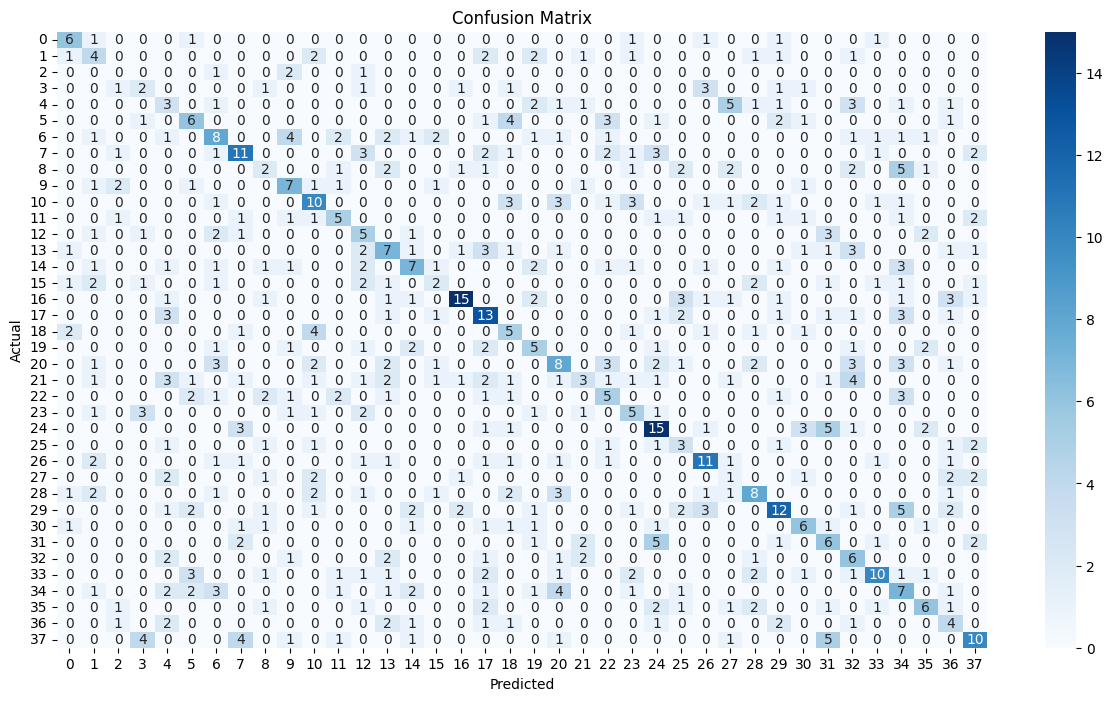

In [249]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)
y_rf_predict=rf.predict(X_test)
plot_actual_vs_predicted(y_rf_predict,title="Actual vs Predicted in Random Forest Classifier ")
evaluate_classification_model(y_test,y_rf_predict)


## 📌 4.K-Nearest Neighbors (KNN) ##


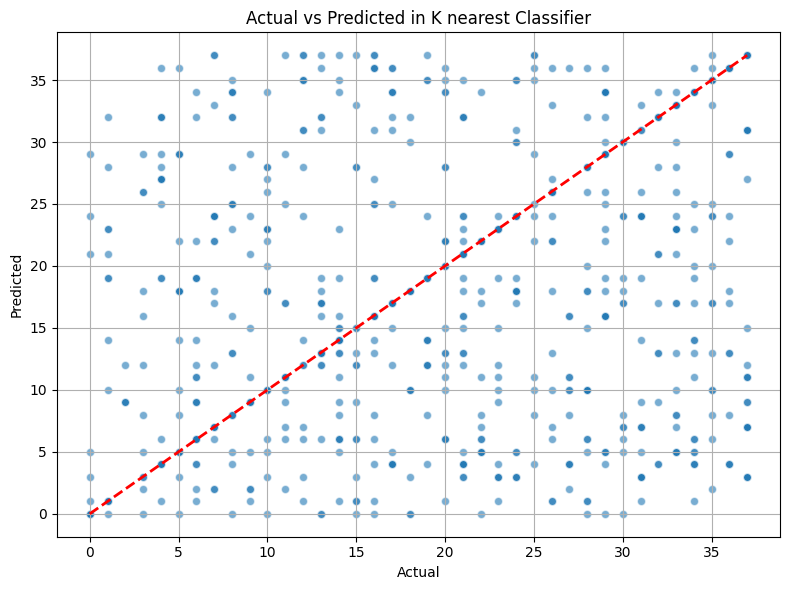

Accuracy:  0.3162
Precision: 0.3491
Recall:    0.3162
F1 Score:  0.3197

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.50      0.36        12
           1       0.26      0.38      0.31        16
           2       0.00      0.00      0.00         4
           3       0.08      0.17      0.11        12
           4       0.16      0.25      0.19        20
           5       0.19      0.30      0.23        20
           6       0.31      0.39      0.35        28
           7       0.46      0.46      0.46        28
           8       0.19      0.15      0.17        20
           9       0.33      0.44      0.38        16
          10       0.36      0.43      0.39        28
          11       0.30      0.38      0.33        16
          12       0.11      0.12      0.12        16
          13       0.31      0.33      0.32        24
          14       0.35      0.25      0.29        24
          15       0.18      0.12      

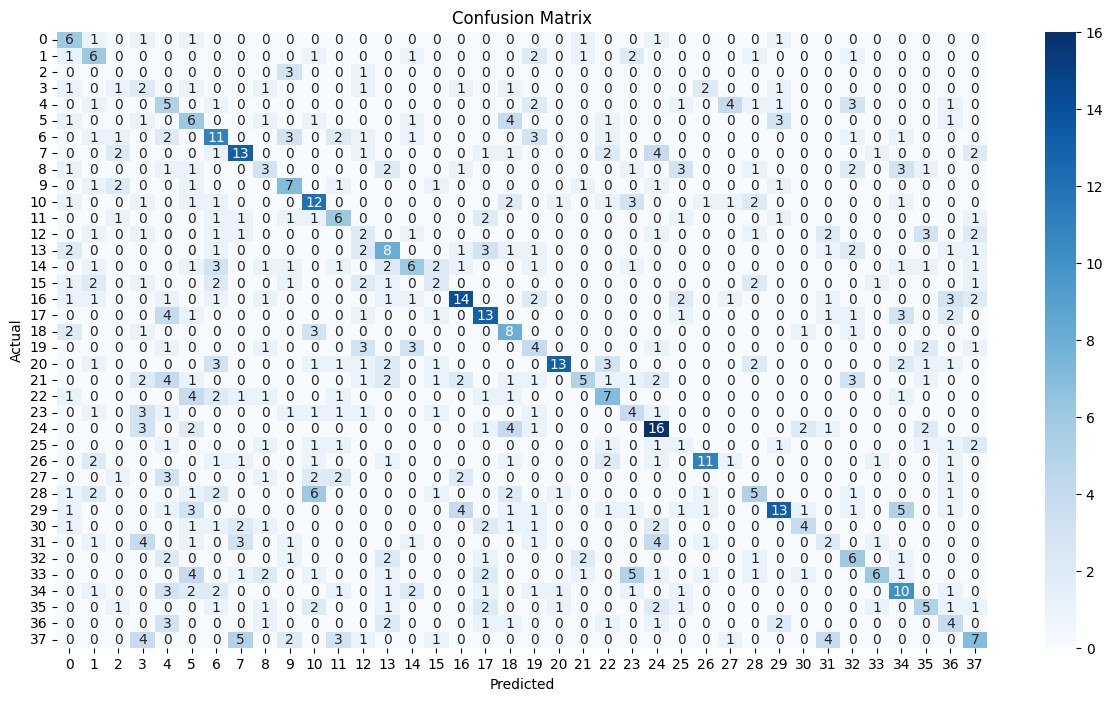

In [228]:
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(X_train, y_train)

# Predict on test data
y_knn_predict = knn.predict(X_test)

plot_actual_vs_predicted(y_knn_predict,title="Actual vs Predicted in K nearest Classifier")
evaluate_classification_model(y_test,y_knn_predict)


## ⚡ 5.Gradient Boosting Classifier ##


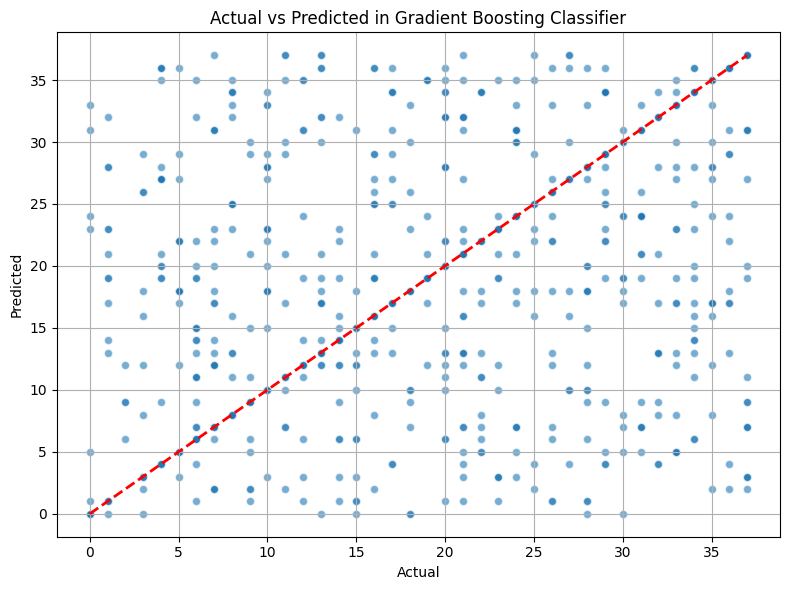

Accuracy:  0.3563
Precision: 0.3866
Recall:    0.3563
F1 Score:  0.3641

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.50      0.46        12
           1       0.22      0.25      0.24        16
           2       0.00      0.00      0.00         4
           3       0.19      0.25      0.21        12
           4       0.27      0.20      0.23        20
           5       0.35      0.35      0.35        20
           6       0.35      0.29      0.31        28
           7       0.30      0.29      0.29        28
           8       0.42      0.25      0.31        20
           9       0.33      0.38      0.35        16
          10       0.50      0.36      0.42        28
          11       0.31      0.31      0.31        16
          12       0.19      0.31      0.24        16
          13       0.25      0.29      0.27        24
          14       0.55      0.46      0.50        24
          15       0.29      0.25      

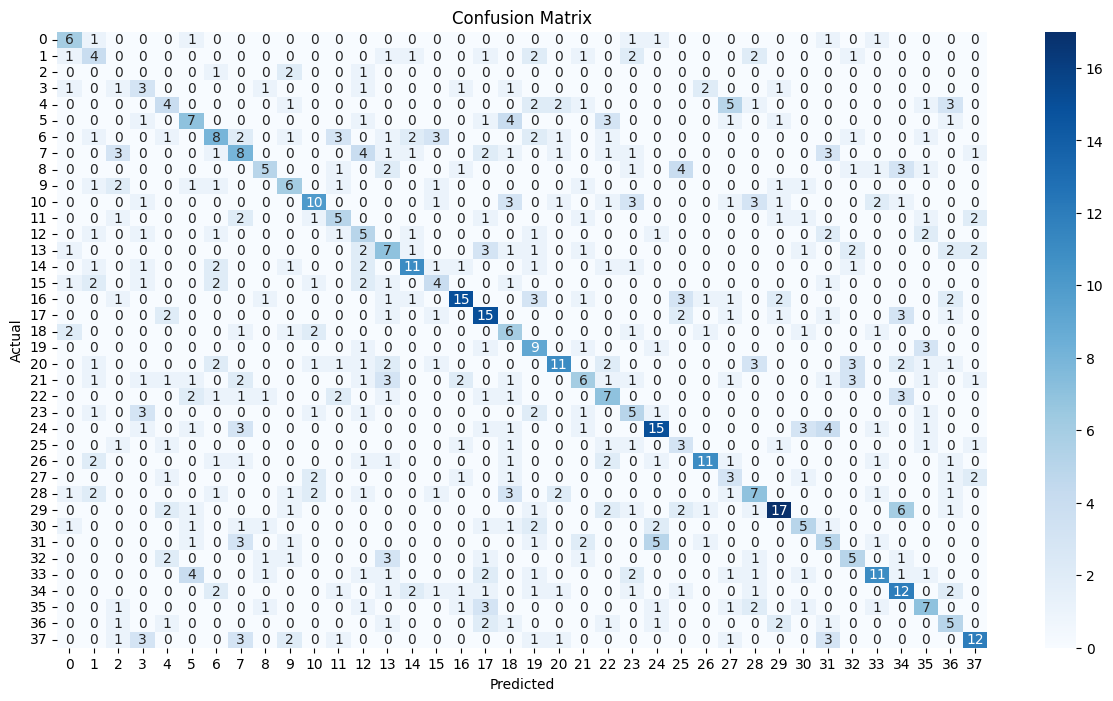

In [229]:

gbc=GradientBoostingClassifier(
    n_estimators=100,      # Number of boosting rounds
    learning_rate=0.1,     # Shrinks contribution of each tree
    max_depth=3,           # Max depth of individual trees
    random_state=42
)



gbc.fit(X_train,y_train)
y_gbc_predict=gbc.predict(X_test)

plot_actual_vs_predicted(y_gbc_predict,title="Actual vs Predicted in Gradient Boosting Classifier")

evaluate_classification_model(y_test,y_gbc_predict)






## 🎲 6.Naive Bayes (GaussianNB) ##

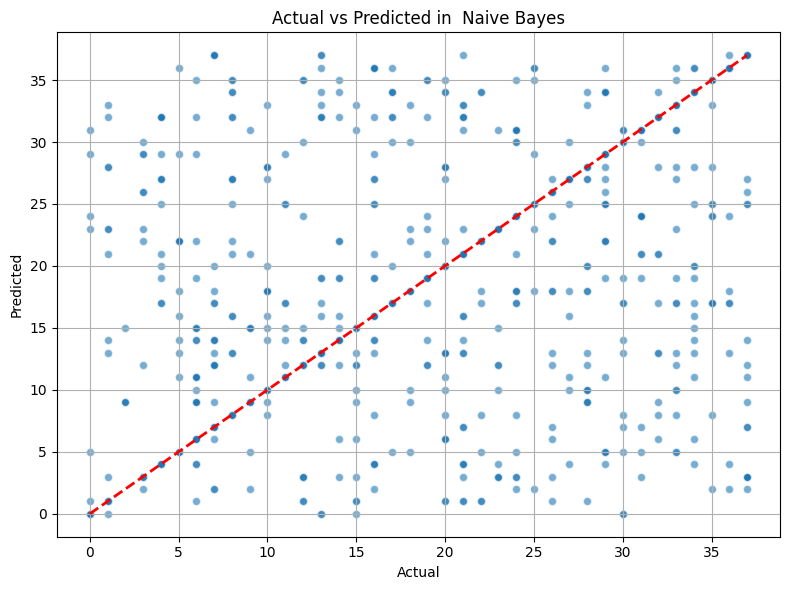

Accuracy:  0.3937
Precision: 0.4269
Recall:    0.3937
F1 Score:  0.3983

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        12
           1       0.26      0.31      0.29        16
           2       0.00      0.00      0.00         4
           3       0.12      0.25      0.17        12
           4       0.28      0.25      0.26        20
           5       0.41      0.45      0.43        20
           6       0.40      0.21      0.28        28
           7       0.53      0.29      0.37        28
           8       0.31      0.20      0.24        20
           9       0.33      0.50      0.40        16
          10       0.54      0.46      0.50        28
          11       0.42      0.50      0.46        16
          12       0.17      0.25      0.21        16
          13       0.29      0.33      0.31        24
          14       0.40      0.50      0.44        24
          15       0.24      0.25      

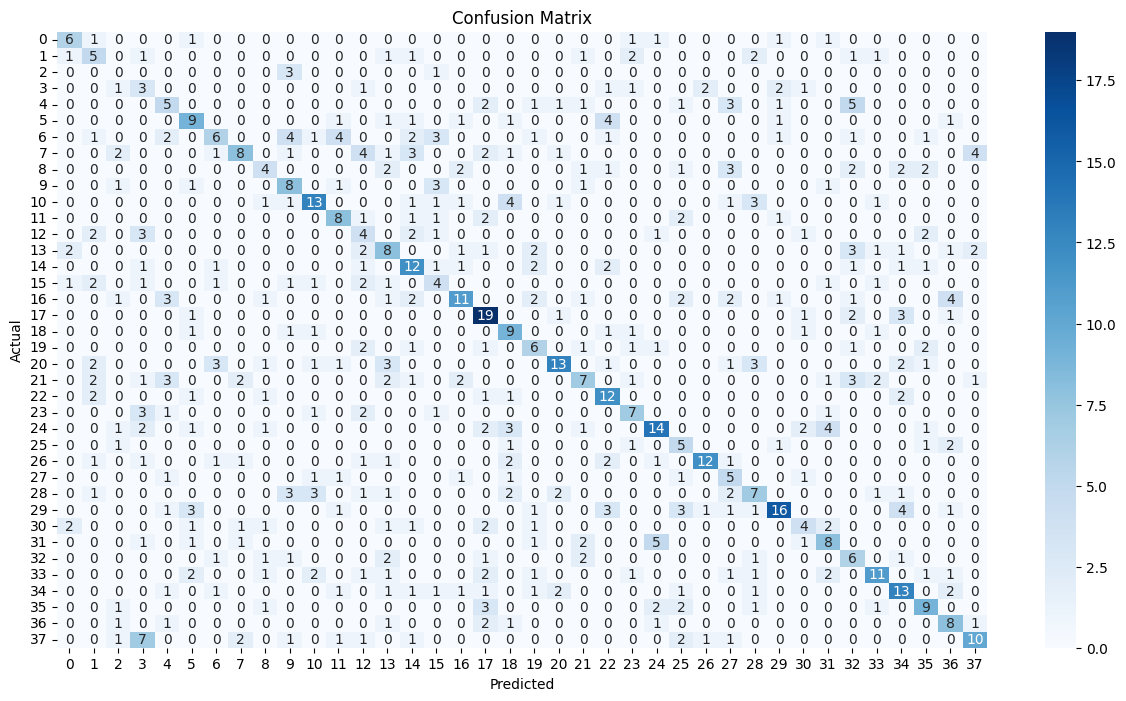

In [230]:
nb = BernoulliNB()
nb.fit(X_train, y_train)
y_nb_predict = nb.predict(X_test)
plot_actual_vs_predicted(y_nb_predict,title="Actual vs Predicted in  Naive Bayes")
evaluate_classification_model(y_test,y_nb_predict)



## ✂️ 7. Support Vector Classifier (SVC) ##


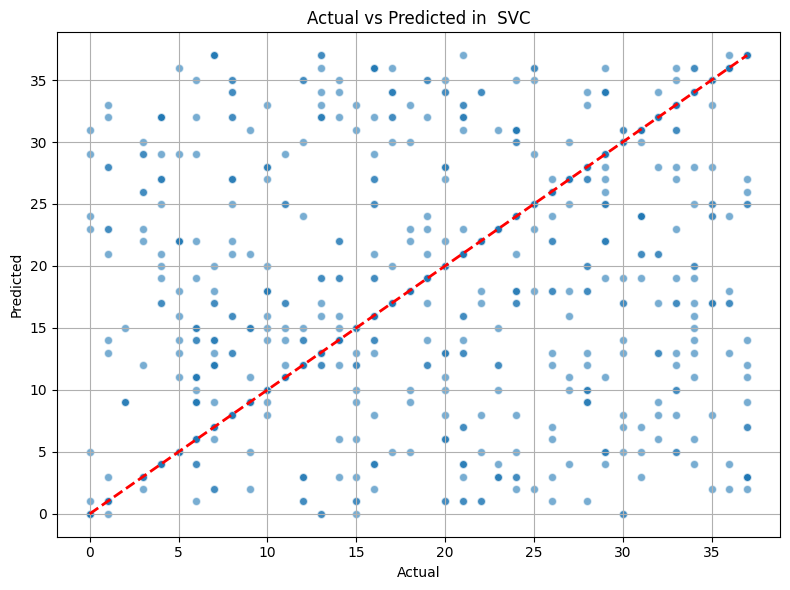

Accuracy:  0.3625
Precision: 0.3837
Recall:    0.3625
F1 Score:  0.3640

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.50      0.46        12
           1       0.25      0.25      0.25        16
           2       0.00      0.00      0.00         4
           3       0.25      0.25      0.25        12
           4       0.12      0.05      0.07        20
           5       0.36      0.25      0.29        20
           6       0.28      0.25      0.26        28
           7       0.35      0.29      0.31        28
           8       0.29      0.20      0.24        20
           9       0.27      0.38      0.32        16
          10       0.59      0.46      0.52        28
          11       0.40      0.38      0.39        16
          12       0.20      0.38      0.26        16
          13       0.25      0.25      0.25        24
          14       0.43      0.50      0.46        24
          15       0.12      0.06      

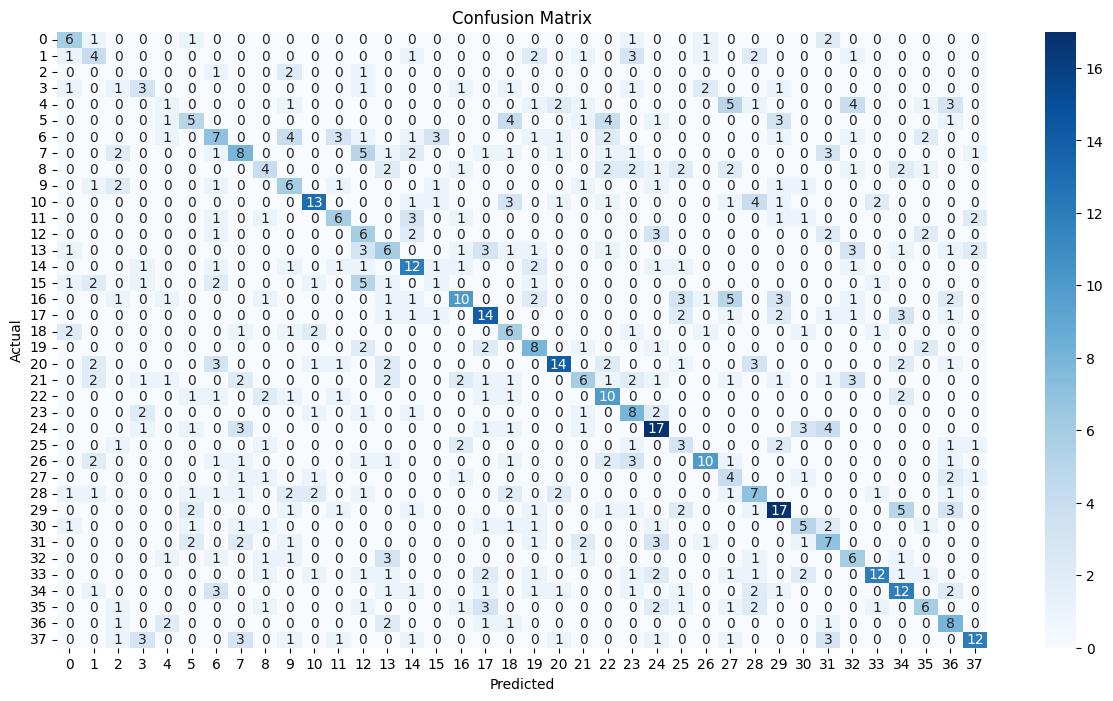

In [231]:
svc = SVC(kernel='rbf', probability=True, random_state=42)

# Train the model
svc.fit(X_train, y_train)

# Predict on test data
y_svc_predict = svc.predict(X_test)
plot_actual_vs_predicted(y_nb_predict,title="Actual vs Predicted in  SVC")

evaluate_classification_model(y_test,y_svc_predict)


Logistic Regression  Accuracy: 0.4062
Decision Tree        Accuracy: 0.2988
Random Forest        Accuracy: 0.3125
K-Nearest Neighbors  Accuracy: 0.3162
Gradient Boosting    Accuracy: 0.3563
Naive Bayes          Accuracy: 0.1900
SVM                  Accuracy: 0.3625


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Classifier       Accuracy: 0.3350


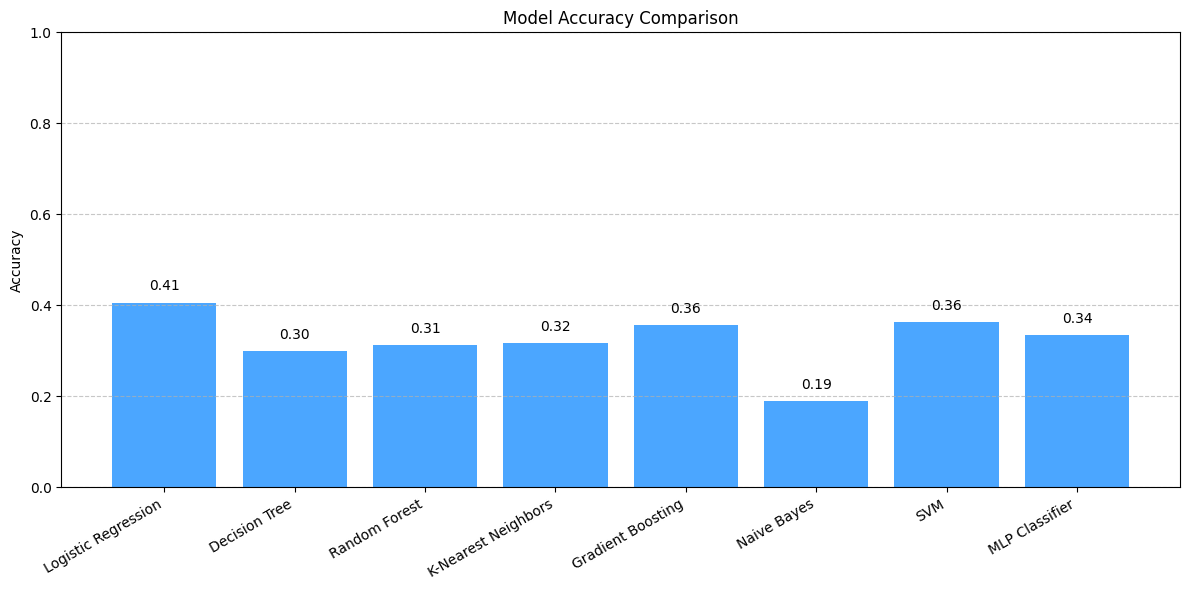

In [232]:
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('SVM', SVC()),
    ('MLP Classifier', MLPClassifier(max_iter=1000)),  # Added here
]

accuracies = []

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"{name:20} Accuracy: {acc:.4f}")

plt.figure(figsize=(12, 6))
bars = plt.bar([name for name, _ in models], accuracies, color='dodgerblue', alpha=0.8)

plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{acc:.2f}", ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# 🧑‍🚀Model Training #

In [233]:

trained_models = {}
for name, model in models:
    model.fit(X_train, y_train)
    trained_models[name] = model

# Step 3: Evaluate models individually
print("Individual Model Accuracies on Test Set:")
model_predictions = []
for name, model in trained_models.items():
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds) * 100
    model_predictions.append(preds)
    print(f"{name:20} Accuracy: {acc:.2f}%")

def majority_vote(predictions):
    count = Counter(predictions)
    return count.most_common(1)[0][0]

final_preds = [
    majority_vote([model_preds[i] for model_preds in model_predictions])
    for i in range(len(y_test))
]

ensemble_acc = accuracy_score(y_test, final_preds) * 100
print(f"\nCombined Model Accuracy on Test Set (Ensemble): {ensemble_acc:.2f}%")

joblib.dump(trained_models, 'trained_models.pkl')
joblib.dump(X.columns, 'symptom_columns.pkl')
joblib.dump(le, 'label_encoder.pkl')










/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Individual Model Accuracies on Test Set:
Logistic Regression  Accuracy: 40.62%
Decision Tree        Accuracy: 29.75%
Random Forest        Accuracy: 31.00%
K-Nearest Neighbors  Accuracy: 31.62%
Gradient Boosting    Accuracy: 35.62%
Naive Bayes          Accuracy: 19.00%
SVM                  Accuracy: 36.25%
MLP Classifier       Accuracy: 30.88%

Combined Model Accuracy on Test Set (Ensemble): 35.75%


['label_encoder.pkl']

# 🧑‍💻Model Evaluation #

In [237]:

trained_models = joblib.load('trained_models.pkl')
symptom_columns = joblib.load('symptom_columns.pkl')
le = joblib.load('label_encoder.pkl')

symptoms_index = {symptom: idx for idx, symptom in enumerate(symptom_columns)}

def normalize_symptom(symptom):
    return symptom.strip().lower().replace(" ", "_")



trained_models = {}
for name, model in models:
    model.fit(X_train, y_train)
    trained_models[name] = model

# Step 3: Evaluate models individually
print("Individual Model Accuracies on Test Set:")
model_predictions = []
for name, model in trained_models.items():
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds) * 100
    model_predictions.append(preds)
    print(f"{name:20} Accuracy: {acc:.2f}%")

# Step 4: Majority voting ensemble evaluation
def majority_vote(predictions):
    count = Counter(predictions)
    return count.most_common(1)[0][0]









def predict_disease(input_symptoms):
    input_symptoms = [normalize_symptom(s) for s in input_symptoms.split(",")]
    
    input_vector = [0] * len(symptom_columns)
    for symptom in input_symptoms:
        if symptom in symptoms_index:
            input_vector[symptoms_index[symptom]] = 1
        else:
            print(f"Warning: Symptom '{symptom}' not found in symptom list.")
    
    input_df = pd.DataFrame([input_vector], columns=symptom_columns)
    
    model_results = {}
    all_preds = []
    
    for name, model in trained_models.items():
        pred_encoded = model.predict(input_df)[0]
        
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(input_df)[0]
            confidence = proba[pred_encoded]
        else:
            confidence = None
        
        pred_label = le.inverse_transform([pred_encoded])[0]
        
        model_results[name] = {
            "prediction": pred_label,
            "confidence": confidence
        }
        
        all_preds.append(pred_encoded)
    
    final_pred_encoded = majority_vote(all_preds)
    final_pred_label = le.inverse_transform([final_pred_encoded])[0]
    
    # Build the output string
    output = "Individual Model Predictions and Confidence:\n"
    for model_name, info in model_results.items():
        conf_str = f"{info['confidence']:.2f}" if info["confidence"] is not None else "N/A"
        output += f"{model_name}: Predicted = {info['prediction']}, Confidence = {conf_str}\n"
    output += f"Final Predicted Disease by Ensemble: {final_pred_label}"
    
    return output






/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Individual Model Accuracies on Test Set:
Logistic Regression  Accuracy: 40.62%
Decision Tree        Accuracy: 29.75%
Random Forest        Accuracy: 29.62%
K-Nearest Neighbors  Accuracy: 31.62%
Gradient Boosting    Accuracy: 35.62%
Naive Bayes          Accuracy: 19.00%
SVM                  Accuracy: 36.25%
MLP Classifier       Accuracy: 32.25%


In [242]:
print(predict_disease("fatigue,nausea"))


Individual Model Predictions and Confidence:
Logistic Regression: Predicted = Paralysis (brain hemorrhage), Confidence = 0.53
Decision Tree: Predicted = Dengue, Confidence = 0.67
Random Forest: Predicted = Dengue, Confidence = 0.66
K-Nearest Neighbors: Predicted = Paralysis (brain hemorrhage), Confidence = 0.60
Gradient Boosting: Predicted = Paralysis (brain hemorrhage), Confidence = 0.48
Naive Bayes: Predicted = Jaundice, Confidence = 1.00
SVM: Predicted = Paralysis (brain hemorrhage), Confidence = N/A
MLP Classifier: Predicted = Dengue, Confidence = 0.46
Final Predicted Disease by Ensemble: Paralysis (brain hemorrhage)
